# Install Torch

In [1]:
torchver = "0.4.0"

In [2]:
!/opt/bin/nvidia-smi || /usr/bin/nvidia-smi

/bin/sh: 1: /opt/bin/nvidia-smi: not found
Wed May 23 23:33:03 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.25                 Driver Version: 390.25                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980     Off  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P2    44W / 185W |    266MiB /  4038MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                 

In [3]:
!ls /colabtools

ls: cannot access '/colabtools': No such file or directory


In [4]:
!python --version

Python 3.6.5 :: Anaconda, Inc.


In [5]:
!pip3 uninstall -y pillow
!CC="cc -mavx2" pip3 install -U --force-reinstall pillow-simd


Uninstalling Pillow-5.1.0:
  Successfully uninstalled Pillow-5.1.0
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Found existing installation: Pillow-SIMD 5.1.1.post0
    Uninstalling Pillow-SIMD-5.1.1.post0:
      Successfully uninstalled Pillow-SIMD-5.1.1.post0


In [6]:

!pip3 install ipdb


tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


In [7]:

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

pver = !python --version |& awk '{print $2 }' | awk -F. '{ print $1$2}'
pyver = pver[0]
print(pyver)

# cver = !echo "cu`nvcc --version | sed "s/ /\n/g" | grep -i release -A 1 | tail -n 1 | tr -d [\.,]`"
# cudaver = cver[0]
cudaver = 'cu91'

accelerator =  cudaver if path.exists('/opt/bin/nvidia-smi') or path.exists('/usr/bin/nvidia-smi') else 'cpu'
print(accelerator)

torchurl = "http://download.pytorch.org/whl/{0}/torch-{1}-cp{2}-cp{2}m-linux_x86_64.whl".format(accelerator, torchver, pyver)
print(torchurl)

!pip3 install http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

import torch
import torchvision
print(torchvision.get_image_backend())

36
cu91
http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/5f/4b/8b54ab9d37b93998c81b364557dff9f61972c0f650efa0ceaf470b392740/Pillow-5.1.0-cp36-cp36m-manylinux1_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
PIL


In [8]:
!pip3 install tqdm

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


# Imports

In [9]:
import torch
import os
import sys
import logging
import io
import time
import shutil
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from argparse import Namespace

In [10]:
%matplotlib inline

# Parameters

In [11]:
args = Namespace()
# base_dir = '/content/fashion'
args.base_dir = '/data/datasets/kaggle_fashion'
args.data_dir = args.base_dir + os.sep + 'data'
args.input_dir = args.data_dir + os.sep + 'input'
args.output_dir = args.data_dir + os.sep + 'output'
args.train_zip = args.input_dir + os.sep + 'train_data.zip'
args.val_zip = args.input_dir + os.sep + 'validation_data.zip'
args.train_dir = args.input_dir + os.sep + 'train_data'
args.val_dir = args.input_dir + os.sep + 'validation_data'
args.train_id = "1rx1rL8RUAggN4hKlrYLtpdQagtUWmIbO"
args.val_id = "1U19eWiBFJ6wGcFk47l6g9mmoWp1i4hPY"
# args.train_labels_id = "1NOoWniR3ioqPKbVWoaWGy4HPDzZAAJX9"
args.train_labels_id = "1X7TpWyxxtmCT5rw__7OKus_W4fh8xpKO" # small dataset
args.val_labels_id = "1d9RuQTx5E8qFxraIu6B4rDTOC4sx2xXT"
args.test_labels_id = "1VwzGCJfOL13pk1Wi-xPHQ6mVnofy9_Z4"
# args.train_labels_json = args.input_dir + os.sep + 'train.json'
args.train_labels_json = args.input_dir + os.sep + 'train_small.json' 
args.val_labels_json = args.input_dir + os.sep + 'validation.json'
args.test_labels_json = args.input_dir + os.sep + 'test.json'
args.num_labels = 228
args.batch_size = 16
args.image_min_size = 256
args.nw_input_size = 224
args.num_workers = 4
args.imagenet_mean = [0.485, 0.456, 0.406]
args.imagenet_std = [0.229, 0.224, 0.225]
args.pretrain_dset_mean = args.imagenet_mean
args.pretrain_dset_std = args.imagenet_std
args.world_size = 1
args.dist_url = 'file://' + args.output_dir + os.sep + 'dfile'
args.dist_backend = 'gloo'
args.distributed = args.world_size > 1
args.arch = 'resnet50'
args.fv_size = 2048
args.pretrained = True
args.resume = False
args.start_epoch = 0
args.small=1e-12                         # small value used for avoiding div by zero
args.optimizer_learning_rate = 1e-6      # Adam optimizer initial learning rate
args.scheduler_patience = 1              # Number of epochs with no improvement after which learning rate will be reduced
args.scheduler_threshold = 1e-3          # learning rate scheduler threshold for measuring the new optimum, to only focus on significant changes
args.scheduler_factor = 0.1              # learning rate scheduler factor by which the learning rate will be reduced. new_lr = lr * factor
args.earlystopping_patience = 1          # early stopping patience is the number of epochs with no improvement after which training will be stopped
args.earlystopping_min_delta = 1e-5      # minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement
args.evaluate = False
args.epochs = 5
args.print_freq = 100
args.ckpt_dir = args.output_dir + os.sep + 'ckpt'
args.ckpt = args.ckpt_dir + os.sep + 'ckpt_%s.pth.tar'

In [12]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


7102
True
GeForce GTX 980


In [13]:
cudnn.benchmark = True

In [14]:
os.makedirs(args.base_dir, exist_ok=True)
os.makedirs(args.data_dir, exist_ok=True)
os.makedirs(args.input_dir, exist_ok=True)
os.makedirs(args.output_dir, exist_ok=True)
os.makedirs(args.ckpt_dir, exist_ok=True)

# Download Dataset

In [15]:
# from google.colab import auth
# auth.authenticate_user()

In [16]:
# from googleapiclient.discovery import build
# import io
# from googleapiclient.http import MediaIoBaseDownload
# import json

# def md5_hash(fname, blocksize=4096):
#     """ compute md5hash of a file """
#     import hashlib
#     hash = ''
#     if not os.path.exists(fname):
#         errmsg = "File %s does not exist" % (fname)
#         print(errmsg)
#         return ''
#     try:
#         hasher = hashlib.md5()
#         with open(fname, 'rb') as f:
#             buf = f.read(blocksize)
#             while len(buf) > 0:
#                 hasher.update(buf)
#                 buf = f.read(blocksize)
#         hash = hasher.hexdigest()
#     except:
#         print("Exception in hashing file")
#         raise
#     return hash

# def _download(drive_service, file_id, loc):
#   request = drive_service.files().get_media(fileId=file_id)
#   fh = io.FileIO(loc, mode='wb')
#   downloader = MediaIoBaseDownload(fh, request, chunksize=1024*1024)
#   prev_progress = 0
#   done = False
#   with tqdm(total=100) as pbar:
#     while done is False:
#       status, done = downloader.next_chunk()
#       if status:
#         # print("Download %d%%." % int(status.progress() * 100))
#         pbar.update(int(100 *(status.progress() - prev_progress)))
#         prev_progress = status.progress()
#   print("Download Complete!")
#   file_size = os.path.getsize(loc)
#   print("Downloaded %d bytes" % (file_size))

# def download(file_id, loc):
#   """Downloads a file to local file system."""  
#   drive_service = build('drive', 'v3')
  
#   request_mdata = drive_service.files().list(fields="files(md5Checksum, originalFilename, id)")
#   rh = io.BytesIO()
#   downloader_mdata = MediaIoBaseDownload(rh, request_mdata, chunksize=1024*1024)
#   done = False
#   while not done:
#     _, done = downloader_mdata.next_chunk()
#   mdata = json.loads(rh.getvalue())
#   found = False
#   md5drive = ''
#   fname = ''
#   for x in mdata['files']:
#     if x['id'] == file_id:
#       found = True
#       md5drive = x['md5Checksum']
#       fname = x['originalFilename']
#       break
#   if not found:
#     print("{:s} : not found on gdrive".format(file_id))
#   else:
#     if os.path.exists(loc):
#       if md5drive == md5_hash(loc):
#         print("{:s} : file already present on colab".format(loc))
#       else:
#         print("{:s} [gdrive] and {:s} [colab] : md5 mismatch ... downloading".format(fname, loc))
#         _download(drive_service, file_id, loc)
#     else:
#       print("{:s} not present on colab ... downloading ...".format(loc))
#       _download(drive_service, file_id, loc)
        


In [17]:
# download(args.train_id, args.train_zip)
# download(args.val_id, args.val_zip)
# download(args.train_labels_id, args.train_labels_json)
# download(args.val_labels_id, args.val_labels_json)
# download(args.test_labels_id, args.test_labels_json)

In [18]:
# import shutil
# shutil.unpack_archive(args.train_zip, args.input_dir)
# shutil.unpack_archive(args.val_zip, args.input_dir)


In [19]:
# !ls -ltr /content/fashion/data/input

In [20]:
# !ls -ltr /content/fashion/data/input/train_data | head

In [21]:
# !ls -ltr /content/fashion/data/input/validation_data | head

# Dataset

In [22]:
import torch.utils.data as data
from copy import copy
import numpy as np

def fetch_labels(annotations, num_labels):
  labels = {}
  for x in annotations:
    arr = np.zeros((num_labels,), dtype=np.float32)
    for y in map(int, x['labelId']):
      arr[y-1] = 1.0
    # 0-indexed
    labels[int(x['imageId'])-1] = copy(arr)
  return labels

def json_to_dict(fpath):
  import json
  with open(fpath) as f: 
    D = json.load(f)
  return D

def get_labelinfo(annotations):
  from collections import namedtuple
  labelinfo = namedtuple('labelinfo', "set min max count")
  labelinfo.set = set()
  for x in annotations:
    labelinfo.set.update(map(int, x['labelId']))
  labelinfo.min = min(labelinfo.set)
  labelinfo.max = max(labelinfo.set)
  labelinfo.count = len(labelinfo.set)
  return labelinfo

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def pil_loader(path):
    from PIL import Image 
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

      
class FashionDataset(data.Dataset):
  """Fashion dataset CVPR challenge.
     Adapted from torchvision ImageFolder.
     Similar to ImageFolder with the following differences:
     1. Multilabel
     2. Directory structure where all images are directly in the root folder
     3. Labels are read from json file
   
  Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
    
  """

  def __init__(self, root, metadata_file, num_labels=228, transform=None, target_transform=None,
               loader=default_loader):
    extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
    self.num_labels = num_labels
    self.images = {}
    self.metadata_file = metadata_file
    self.metadata = json_to_dict(self.metadata_file)
    self.transform = transform
    self.root = root
    self.target_transform = target_transform
    self.loader = loader
    self.labelinfo = get_labelinfo(self.metadata['annotations'])
    self.labels = fetch_labels(self.metadata['annotations'], self.num_labels)

    for x in self.metadata['images']:
      # 0-indexed
      self.images[int(x['imageId'])-1] = '%s%s%d.jpg' % (root, os.sep, int(x['imageId']))  
    

  def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.images[index], self.labels[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

  def __len__(self):
    return len(self.images)
  
  def __repr__(self):
    fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
    fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
    fmt_str += '    Number of labels: {}\n'.format(self.labelinfo.count)
    fmt_str += '    Root Location: {}\n'.format(self.root)
    fmt_str += '    Metadata file: {}\n'.format(self.metadata_file)
    tmp = '    Transforms (if any): '
    fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Target Transforms (if any): '
    fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Loader: '
    fmt_str += '\n{0}{1}'.format(tmp, self.loader.__name__)
    return fmt_str

  

In [23]:
import torchvision.transforms as transforms

train_tform = transforms.Compose([transforms.RandomResizedCrop(args.nw_input_size),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=args.pretrain_dset_mean,
                                                        std=args.pretrain_dset_std)
                                 ])

val_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                transforms.CenterCrop(args.nw_input_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=args.pretrain_dset_mean,
                                                     std=args.pretrain_dset_std)
                               ])

In [24]:
train_dset = FashionDataset(args.train_dir, args.train_labels_json, args.num_labels, transform=train_tform)
val_dset = FashionDataset(args.val_dir, args.val_labels_json, args.num_labels, transform=val_tform)


print(train_dset)
print(val_dset)

Dataset FashionDataset
    Number of datapoints: 10000
    Number of labels: 221
    Root Location: /data/datasets/kaggle_fashion/data/input/train_data
    Metadata file: /data/datasets/kaggle_fashion/data/input/train_small.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7fd7e5580b00>
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 9897
    Number of labels: 225
    Root Location: /data/datasets/kaggle_fashion/data/input/validation_data
    Metadata file: /data/datasets/kaggle_fashion/data/input/validation.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7fd7e5580c18>
    Target Transforms (if any): None
    Loader: default_loader


In [25]:
def tensor_to_numpy(t, avg, std):
  return (255.0 * (np.transpose(np.asarray(t), (1, 2, 0)) * std + avg)).astype(np.uint8)
  

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


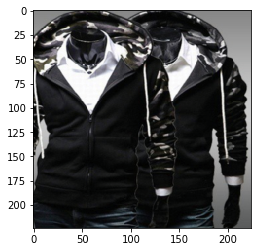

In [26]:
rnd1 = np.random.randint(len(train_dset))
im1, lbl1 = train_dset[rnd1]
imshow(tensor_to_numpy(im1, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


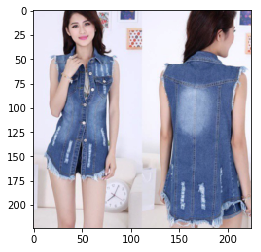

In [27]:
rnd2 = np.random.randint(len(val_dset))
im2, lbl2 = val_dset[rnd2]
imshow(tensor_to_numpy(im2, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl2)

# DataLoader

In [28]:
if args.distributed:
    dist.init_process_group(backend=args.dist_backend,
                            init_method=args.dist_url,
                            world_size=args.world_size)


In [29]:
from torch.utils.data.distributed import DistributedSampler 


if args.distributed:
  train_sampler = DistributedSampler(train_dset)
else:
  train_sampler = None

train_loader = torch.utils.data.DataLoader(train_dset,
                                           batch_size=args.batch_size,
                                           shuffle=(train_sampler is None),
                                           num_workers=args.num_workers,
                                           pin_memory=True,
                                           sampler=train_sampler
                                          )

val_loader = torch.utils.data.DataLoader(val_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )


In [30]:
# train_images, train_labels = next(iter(train_loader))

In [31]:
# rnd11 = np.random.randint(args.batch_size)
# print(train_images[rnd11,:,:,:])
# print(train_labels[rnd11, :])

In [32]:
# val_images, val_labels = next(iter(val_loader))

In [33]:
# rnd21 = np.random.randint(args.batch_size)
# print(val_images[rnd21,:,:,:])
# print(val_labels[rnd21, :])


# Model

In [34]:
import torch.nn.init as weight_init


class FCWithLogSigmoid(nn.Module):
  
  def __init__(self, num_inputs, num_outputs):
    super(FCWithLogSigmoid, self).__init__()
    self.linear = nn.Linear(num_inputs, num_outputs)
    self.logsigmoid = nn.LogSigmoid()
    
  def forward(self, x):
    return self.logsigmoid(self.linear(x))


def create_model(arch, num_labels=228, fv_size=2048, pretrained=True, resume=False, distributed=False):
  if pretrained:
      print("=> using pre-trained model '{}'".format(arch))
      model = models.__dict__[arch](pretrained=True)
  else:
      print("=> creating model '{}'".format(arch))
      model = models.__dict__[arch]()
  model.fc = FCWithLogSigmoid(fv_size, num_labels)
  if not distributed:
      if arch.startswith('alexnet') or arch.startswith('vgg'):
          model.features = torch.nn.DataParallel(model.features)
          model.cuda()
      else:
          model = torch.nn.DataParallel(model).cuda()
  else:
      model.cuda()
      model = torch.nn.parallel.DistributedDataParallel(model)
  return model


In [35]:
def count_parameters(model):
  """source: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [36]:
model = create_model(args.arch,
                     num_labels=args.num_labels,
                     fv_size=args.fv_size,
                     pretrained=args.pretrained,
                     resume=args.resume,
                     distributed=args.distributed)

=> using pre-trained model 'resnet50'


In [37]:
print("Neural Network has ", count_parameters(model), " trainable parameters")

Neural Network has  23975204  trainable parameters


# Loss Function


In [38]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

# Update Rule

In [39]:
optimizer = optim.Adam(model.parameters(),
                       amsgrad=True,
                       lr=args.optimizer_learning_rate,
                       betas=(0.9, 0.999),
                       eps=1e-8,
                       weight_decay=0.0
                      )
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                           mode='max',   # F1 measure
                                           patience=args.scheduler_patience,
                                           threshold=args.scheduler_threshold,
                                           factor=args.scheduler_factor,
                                           verbose=1
                                          )


# Training Loop


In [40]:
def load_checkpoint(model, optimizer, scheduler, args, resume=True, ckpt=None):
    """optionally resume from a checkpoint."""
    best_f1 = 0
    if args.resume:
        if os.path.isfile(ckpt):
            print("=> loading checkpoint '{}'".format(ckpt))
            checkpoint = torch.load(ckpt)
            args.start_epoch = checkpoint['epoch']
            best_f1 = checkpoint['best_f1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
          #  scheduler.load_state_dict(checkpoint['scheduler'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(ckpt))
            best_f1 = 0
    return (model, optimizer, scheduler, args, best_f1)

In [41]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [42]:
class F1MicroAverageMeter(object):
    """Computes and stores F1 store"""
    def __init__(self, threshold=0.5, small=1e-12):
        self.threshold = threshold
        self.small = small
        self.reset()

    def reset(self):
        self.TP = 0.0
        self.FP = 0.0
        self.FN = 0.0
        self.TN = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0

    def update(self, labels, pred):
        tp, fp, fn, tn = self.confusion_matrix_(labels, pred)
        self.TP += tp
        self.FP += fp
        self.FN += fn
        self.TN += tn
        self.precision = self.TP / (self.small + self.TP + self.FP)
        self.recall = self.TP / (self.small + self.TP + self.FN)
        self.f1 = (2.0 * self.precision * self.recall) / (self.small + self.precision + self.recall)
        
    def confusion_matrix_(self, labels, pred):
        with torch.no_grad():
            real = labels
            fake = 1.0 - real
            pos = pred.ge(self.threshold).float()
            neg = 1.0 - pos
            tp = torch.sum(real * pos).item()
            fp = torch.sum(fake * pos).item()
            fn = torch.sum(real * neg).item()
            tn = torch.sum(fake * neg).item()
            return (tp, fp, fn, tn)
              

In [43]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [44]:
def adjust_learning_rate(optimizer, scheduler, epoch, measure):
    scheduler.step(measure)


In [45]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure F1 and record loss
        losses.update(loss.item(), input.size(0))
        cmpoint5.update(target, torch.exp(output))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Precision {cmpoint5.precision:.3f}\t'
                  'Recall {cmpoint5.recall:.3f}\t'
                  'F1 {cmpoint5.f1:.3f}'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, cmpoint5=cmpoint5))

In [46]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure F1 and record loss
            losses.update(loss.item(), input.size(0))
            cmpoint5.update(target, torch.exp(output))
            

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Precision {cmpoint5.precision:.3f}\t'
                      'Recall {cmpoint5.recall:.3f}\t'
                      'F1 {cmpoint5.f1:.3f}'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       cmpoint5=cmpoint5))

        print(' * Precision {cmpoint5.precision:.3f} Recall {cmpoint5.recall:.3f} F1 {cmpoint5.f1:.3f}'
              .format(cmpoint5=cmpoint5))

    return cmpoint5.f1

In [47]:
if args.evaluate:
    validate(val_loader, model, criterion)
else:
    model, optimizer, scheduler, args, best_f1 = load_checkpoint(model, optimizer, scheduler, args, resume=args.resume, ckpt=args.ckpt)
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
#         adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        f1 = validate(val_loader, model, criterion)

        # remember best f1 and save checkpoint
        is_best = f1 > best_f1
        best_f1 = max(f1, best_f1)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.arch,
            'state_dict': model.state_dict(),
            'best_f1': best_f1,
            'optimizer' : optimizer.state_dict(),
           # 'scheduler' : scheduler.state_dict(),
        }, is_best)
        
        adjust_learning_rate(optimizer, scheduler, epoch, f1)
        


Epoch: [0][0/625]	Time 3.954 (3.954)	Data 1.072 (1.072)	Loss 0.4214 (0.4214)	Precision 0.029	Recall 0.531	F1 0.055
Epoch: [0][100/625]	Time 0.203 (0.239)	Data 0.000 (0.011)	Loss 0.4097 (0.4132)	Precision 0.031	Recall 0.519	F1 0.058
Epoch: [0][200/625]	Time 0.206 (0.221)	Data 0.000 (0.006)	Loss 0.3898 (0.4059)	Precision 0.034	Recall 0.492	F1 0.063
Epoch: [0][300/625]	Time 0.202 (0.215)	Data 0.000 (0.004)	Loss 0.3757 (0.3985)	Precision 0.037	Recall 0.462	F1 0.068
Epoch: [0][400/625]	Time 0.211 (0.213)	Data 0.000 (0.004)	Loss 0.3604 (0.3907)	Precision 0.040	Recall 0.435	F1 0.073
Epoch: [0][500/625]	Time 0.205 (0.211)	Data 0.000 (0.003)	Loss 0.3428 (0.3829)	Precision 0.043	Recall 0.409	F1 0.078
Epoch: [0][600/625]	Time 0.206 (0.210)	Data 0.000 (0.003)	Loss 0.3266 (0.3751)	Precision 0.046	Recall 0.386	F1 0.082
Test: [0/619]	Time 1.155 (1.155)	Loss 0.3287 (0.3287)	Precision 0.155	Recall 0.195	F1 0.173
Test: [100/619]	Time 0.060 (0.156)	Loss 0.3252 (0.3277)	Precision 0.172	Recall 0.226	F1 0.1

# Save Results